## Preface



First, load relevant dataset:



In [23]:
!pip install CFEDemands
import cfe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


fct = pd.read_csv('fct-full-fct-full.csv').dropna(how='all')
fct.set_index('Item name', inplace= True)


r = cfe.from_dataset('TanzanianNPS/tanzanian_nps.ds')

# Note selection of prices from 2014 and first market.
t= 2014
m= 1

p = r.prices.sel(t=t, m=m).fillna(1).copy()
newp = pd.read_csv('our-prices.csv')
p.values = newp.iloc[:,0].values

# We will explore nutrition and policy options with respect to demand of this staple good
USE_GOOD = "Sweet Potatoes"

def my_prices(p0,p=p,i=USE_GOOD):
    p = p.copy()
    newp = pd.read_csv('our-prices.csv')
    p.values = newp.iloc[:,0].values
    p.loc[i] = p0
    return p

# Now fix up FCT
# Change some labels

d={'Item name': 'Item',
   'protein g':'Protein',
   'energy kcal':'Calories',
   'ca mg':'Calcium',
   'mg mg': 'Magnesium',
   'fe mg':'Iron',
   'zn mg':'Zinc',
   'vit a ug':'Vitamin A',
   'vit d ug':'Vitamin D',
   'vit e ug':'Vitamin E',
   'vit c mg':'Vitamin C',
   'vit b6 mg': 'Vitamin B6'}

fct = fct.rename(columns=d) #[list(d.values())]


# Replace missing with zeros
fct = fct.fillna(0)

try:
    fct.index = fct.index.droplevel('unit')
except AttributeError: pass # No units?

def nutrient_demand(x,p,z=None):
    c = r.demands(x,p,z=z)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    fct0= fct0.replace(np.nan,0)
    N = fct0.T@c0

    return N

# Import recommended minimum daily nutritional requirements
rda = pd.read_csv('Tanzania Daily Nutrition Minimum Requirement - nutrition-final.csv').set_index(['age'])

#change some labels
d={'child02': 'C 0-2',
   'child25': 'C 2-5',
   'child69': 'C 6-9',
   'child1014':'C 10-14',
   'child1517':'C 15-17',
   'men': 'Men',
   'women': 'Women'}

e={'protein (g)':'Protein',
   'energy (kcal)':'Calories',
   'calcium (mg)':'Calcium',
   'magnesium (mg)': 'Magnesium',
   'iron (mg)':'Iron',
   'zinc (mg)':'Zinc',
   'vitamin a (ug)':'Vitamin A',
   'vitamin d (ug)':'Vitamin D',
   'vitamin e (ug)':'Vitamin E',
   'vitamin c (mg)':'Vitamin C'
   #'vit b6 mg': 'Vitamin B6'
  }

   
rda = rda.rename(index=d).rename(columns=e)[list(e.values())]

# In first round, averaged over households and villages, zbar is the average household but in our own experiements can 
# make zbar equal to households only with children
zbar = r.z.sel(t=r.firstround).mean(['j','m'])[:-1] # Leave out log HSize

# This matrix product gives minimum nutrient requirements for average
# household in first round
rda
hh_rda = rda.replace('',0).T@zbar

def nutrient_adequacy_ratio(x,p):
    return nutrient_demand(x,p)/hh_rda

In [18]:
fct.head()

,Calories,Protein,Vitamin A,Vitamin D,Vitamin E,Vitamin C,Vitamin B6,vit b12 ug,Calcium,Magnesium,Iron,Zinc
Item name,,,,,,,,,,,,
Rice (Paddy),358.0,6.5,0.0,0.0,0.0,0.0,0.1,0.0,8.0,36.0,0.6,1.1
Rice (Husked),358.0,6.5,0.0,0.0,0.0,0.0,0.1,0.0,8.0,36.0,0.6,1.1
"Maize (Green, Cob, immature)",59.0,1.8,7.0,0.0,0.0,3.0,0.0,0.0,1.0,18.0,0.3,0.3
"Maize (Grain, dry, raw)",362.0,8.1,0.0,0.0,1.0,0.0,0.3,0.0,6.0,127.0,3.5,1.8
Maize (Flour),362.0,8.1,0.0,0.0,1.0,0.0,0.3,0.0,6.0,127.0,3.5,1.8


## Simple Policy Experiments



We will consider two policies: First, changing income so that some proportion
of the population achieves nutritional adequacy. In this example, we will use the median household budget of 6311 tanzanian shillings.

In [19]:
# Assign Budget (median household)
x0 = 6311

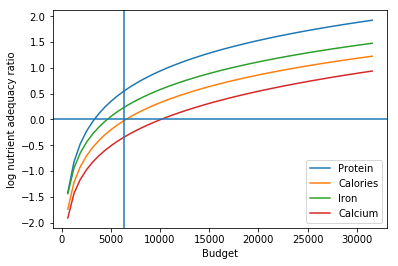

In [34]:
# We will plot the nutritional outcomes for a median household budget

import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(x0/10,x0*5,50)

UseNutrients = ['Protein','Calories','Iron','Calcium']
plt.plot(X,pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(x0)

This shows that for an entire diet to achieve nutritional adequacy, people need a budget equivalent to ~11,000 Shillings. These curves are Engel curves for general nutritional outcomes and simulates what an income transfer would look like. This policy simulation assumes no transaction costs, assumes the nutrient demand system doesn't take into account other utilities for other goods, assumes that income transfer won't change prices, that household size stays the same, and that the supply curve is perfectly elastic from competition or trade, and constant economies of scale.

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



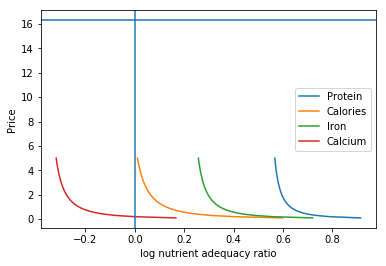

In [24]:
median_x = x0
USE_GOOD = "Sweet Potatoes"

ref_price = r.prices.sel(i=USE_GOOD,t=t,m=m)
P = np.linspace(ref_price/10,ref_price*5,50)

plt.plot(pd.concat({p0:np.log(nutrient_adequacy_ratio(median_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P},axis=1).T,P)
plt.legend(UseNutrients)
plt.ylabel('Price')
plt.xlabel('log nutrient adequacy ratio')
plt.axvline(0)
plt.axhline(p.sel(i=USE_GOOD).values)

This plot shows that as prices decreases for sweet potatoes, the typical household's nutritent adequacy ratio increases. At around 5 shillings, households are able to achieve nutrient adequacy for protein, calories, and iron. However for calcium adequacy, the household requires a price closer to 0.

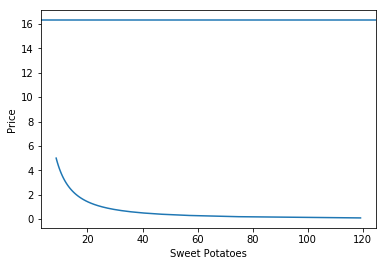

In [29]:
# Now we will plot the demand curve for sweet potatoes. 

USE_GOOD = "Sweet Potatoes"
plt.plot([r.demands(median_x,my_prices(p0,i=USE_GOOD))[USE_GOOD] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(USE_GOOD)
plt.axhline(p.sel(i=USE_GOOD).values)

As you can see, as price increases, the quantity demanded of sweet potatoes decreases. As price decreases, the quantity demanded of sweet potatoes increases.

## Compensated Policy Experiments



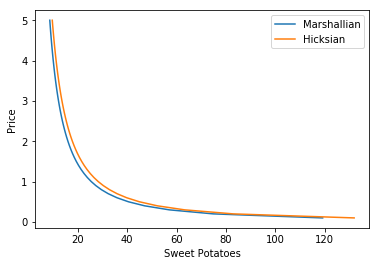

In [33]:
# Now we will plot Marshallian and Hicksian demand curves for sweet potatoes 

U0 = cfe.demands.marshallian.indirect_utility(x0,p,np.exp(r.alpha),r.beta,0)

plt.plot([r.demands(median_x,my_prices(p0,i=USE_GOOD))[USE_GOOD] for p0 in P],P)
plt.plot([r.demands(median_x,my_prices(p0,i=USE_GOOD),type="Hicksian")[USE_GOOD] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(USE_GOOD)
#plt.axhline(p.sel(i=USE_GOOD).values)
plt.legend(("Marshallian","Hicksian"))

Hicksian demand curves show the relationship between the price of a good and the quantity demanded of it assuming that the prices of other goods and our level of utility remain constant. Marshallian demand curves reflect both rent effect and substitution effect.

In [32]:
# Now we will calculate how much we need to spend to achieve the same utility with old prices and
# how much we need to spend to achieve utility with new prices  (x1- x0)

def compensating_variation(U0,p0,p1):
    p = r.prices.sel(t=t,m=m).fillna(1).copy()
    newp = pd.read_csv('our-prices.csv')
    p.values = newp.iloc[:,0].values
    x0 = cfe.demands.hicksian.expenditurefunction(U0,p0,np.exp(r.alpha),r.beta,0)
    x1 =  cfe.demands.hicksian.expenditurefunction(U0,p1,np.exp(r.alpha),r.beta,0)

    return x1-x0

compensating_variation(U0,p,my_prices(1))

-115.7734935838671

If we decrease prices from 16 shillings to 1 shilling for 100 grams of sweet potatoes, we can also take away 115.8 shillings from the household and they would be just as well off.